Este código es parte de una implementación de un modelo de red neuronal usando Keras para clasificar dígitos del conjunto de datos MNIST. Aquí está el desglose de cada bloque de código en detalle.

1. Importación de Bibliotecas y Configuración de la Semilla Aleatoria

Se importan varias bibliotecas necesarias:

- numpy para manipulación de arreglos y datos.
- matplotlib.pyplot para visualización de datos (si se requiere).
- os para configuraciones del entorno.
- keras y keras_tuner, bibliotecas de alto nivel para construir y entrenar redes neuronales.

## Carga del Conjunto de Datos MNIST

`keras.utils.set_random_seed(23)`

Aquí se establece una semilla aleatoria para los generadores aleatorios en Keras. Esto garantiza que los resultados sean reproducibles; en este caso, la semilla está fijada en 23, de manera que si se vuelve a ejecutar este código, los resultados serán los mismos cada vez.

`(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()`

El conjunto de datos MNIST contiene imágenes de dígitos escritos a mano (del 0 al 9) en escala de grises. Este código carga los datos en cuatro conjuntos:

- x_train_val y y_train_val: Datos de entrada y etiquetas para entrenamiento y validación combinados.
- x_test y y_test: Datos de entrada y etiquetas para pruebas.

El conjunto `x_train_val` contiene imágenes de entrenamiento y validación combinadas, que luego se dividirán en subconjuntos más adelante en el código.

## Preprocesamiento de los datos

Las imágenes originales en MNIST son de 28x28 píxeles (784 píxeles en total).

``` python
input_dim = 784
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
```

- La dimensión input_dim se establece en 784 para que cada imagen se convierta en un vector unidimensional de longitud 784.
- reshape(-1, input_dim): Cambia la forma de cada imagen 28x28 a un vector de 784 valores, adecuado para un modelo de red neuronal densa.
- astype("float32") / 255.0: Convierte los valores de enteros (0 a 255) a flotantes (0.0 a 1.0) dividiendo por 255. Esto normaliza los datos, lo cual es beneficioso para el entrenamiento de redes neuronales.

```python
num_classes = 10
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
```

Se define num_classes como 10 porque hay 10 clases (dígitos del 0 al 9).
to_categorical convierte las etiquetas (por ejemplo, el número 5) en etiquetas categóricas o one-hot encoded (por ejemplo, [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]). Esto transforma las etiquetas para que sean compatibles con la salida del modelo en la clasificación.

```python
x_train = x_train_val[:-10000]
x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]
y_val = y_train_val[-10000:]
```

Este código divide el conjunto x_train_val en dos partes:

- x_train: La mayor parte de los datos para el entrenamiento.
- x_val: Los últimos 10,000 ejemplos de x_train_val se utilizan para validación.

La validación es importante para evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento. Las etiquetas correspondientes (y_train y y_val) se dividen de la misma manera.

**Keras Tuner es una biblioteca de código abierto desarrollada para ajustar automáticamente los hiperparámetros de modelos de redes neuronales en Keras. Los hiperparámetros son configuraciones del modelo que afectan su rendimiento, como el número de capas, el tamaño de las capas, la tasa de aprendizaje, etc. Ajustar estos hiperparámetros manualmente puede ser tedioso y consumir mucho tiempo, por lo que Keras Tuner facilita esta tarea mediante técnicas de búsqueda como búsqueda aleatoria, búsqueda en hiperband y optimizaciones bayesianas.**

In [1]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner

keras.utils.set_random_seed(23); input_dim = 784; num_classes = 10
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]

2024-11-15 01:51:47.916088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731631907.929348  618664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731631907.933514  618664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


This code defines a custom hypermodel class, MyHyperModel, that inherits from keras_tuner.HyperModel. It specifies both the architecture and training process of the model, including tunable hyperparameters like learning rate and batch size. Let’s go through each part in detail.

```python
def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(784,)))
    M.add(keras.layers.Dense(units=800, activation='relu'))
    M.add(keras.layers.Dense(10, activation='softmax'))
```
- Purpose: The build method defines the architecture of the model.
- Input Layer: An input layer with shape (784,), suitable for the MNIST dataset (28x28 pixels flattened).
- Hidden Layer: A single dense layer with 800 units and ReLU activation.
- Output Layer: A dense layer with 10 units (one per class) and softmax activation for multiclass classification.

```python 
learning_rate = hp.Float("lr", min_value=0.00006, max_value=0.00026)
```

Learning Rate Hyperparameter: hp.Float allows Keras Tuner to tune the learning rate between 0.00006 and 0.00026.

```python
opt = keras.optimizers.Adam(learning_rate=learning_rate)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
```
Optimizer: Adam is used, with the learning rate set to the tunable learning_rate hyperparameter.

Compilation: The model is compiled with categorical_crossentropy loss (for multiclass classification) and accuracy as the evaluation metric.

```python
def fit(self, hp, M, x, y, xy_val, **kwargs):
```

- hp: provides access to hyperparameters...
- M: The model instance created in build.
- x, y: Training data and labels.
- xy_val: Validation data and labels.
- **kwargs: Additional arguments passed to fit.

```python
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
kwargs['callbacks'].append(early_cb)
```
Early Stopping Callback: Early stopping monitors val_accuracy and stops training if accuracy does not improve after 10 epochs (patience) with a minimum improvement (min_delta) of 1e-5

```python
return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)
```
Model Training: The model is trained using the specified batch size (bs) and for up to 100 epochs. Training can stop early if the EarlyStopping callback triggers.

Validation Data: xy_val is used to evaluate the model on each epoch, guiding the early stopping callback.

**The MyHyperModel class defines a model and training setup with tunable learning rate and batch size hyperparameters. The class integrates with Keras Tuner to optimize these values, using early stopping to prevent overfitting and minimize training time. This setup allows you to find the best-performing model configuration more efficiently.**

In [2]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        M = keras.Sequential()
        M.add(keras.Input(shape=(784,)))
        M.add(keras.layers.Dense(units=800, activation='relu'))
        M.add(keras.layers.Dense(10, activation='softmax'))
#        learning_rate = hp.Float("lr", min_value=1e-5, max_value=0.01, step=2, sampling="log")
#        lr: 0.00016 batch_size: 256 Score: 0.8977
        learning_rate = hp.Float("lr", min_value=0.00006, max_value=0.00026)
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return M

    def fit(self, hp, M, x, y, xy_val, **kwargs):
        bs = hp.Int("batch_size", 128, 256, step=2, sampling="log")
        early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-5)
        kwargs['callbacks'].append(early_cb)
        return M.fit(x, y, batch_size=bs, epochs=100, validation_data=xy_val, **kwargs)


In [3]:
tuner = keras_tuner.BayesianOptimization(
MyHyperModel(), objective="val_accuracy", max_trials=3,
overwrite=True, directory="/tmp", project_name="Fashion-MNIST"
)

tuner.search(x_train, y_train, (x_val, y_val))

tuner.results_summary(num_trials=1)

best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

opt = keras.optimizers.Adam(learning_rate=0.00015)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=20, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Trial 3 Complete [00h 00m 23s]
val_accuracy: 0.8884000182151794

Best val_accuracy So Far: 0.8953999876976013
Total elapsed time: 00h 01m 14s
Results summary
Results in /tmp/Fashion-MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
lr: 0.00014936675501468113
batch_size: 256
Score: 0.8953999876976013


/home/yassin/anaconda3/envs/per/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.3258
Precisión: 88.95%
Loss: 0.3083
Precisión: 89.69%


In [4]:
opt = keras.optimizers.Adam(learning_rate=0.00015)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(x_train_val, y_train_val, batch_size=256, epochs=20, validation_data=(x_test, y_test), verbose=0)
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.3198
Precisión: 89.69%


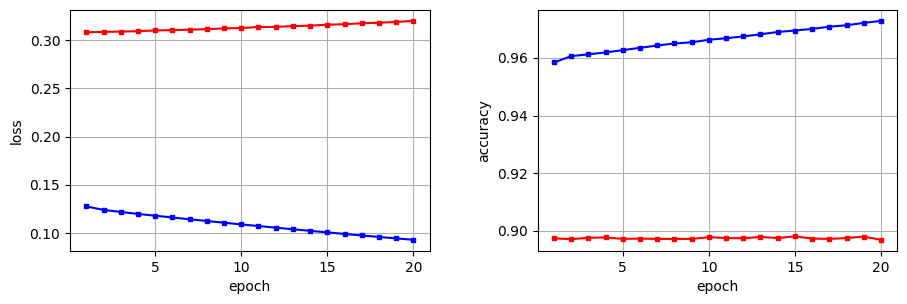

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
fig.tight_layout(); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', marker='s', markersize=3)
ax.plot(xx, H.history['val_loss'], color='r', marker='s', markersize=3)
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', marker='s', markersize=3)
ax.plot(xx, H.history['val_accuracy'], color='r', marker='s', markersize=3);